In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import pickle
from collections import Counter

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

In [62]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')


stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [63]:
# Load data
df = pd.read_csv("amazon_reviews.csv")
df = df[['reviews.text', 'reviews.rating']].dropna()
df = df.rename(columns={'reviews.text': 'review', 'reviews.rating': 'rating'})


C:\Users\DELL\AppData\Local\Temp\ipykernel_16340\1989103032.py:2: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("amazon_reviews.csv")



🔍 Basic Info:
<class 'pandas.core.frame.DataFrame'>
Index: 34626 entries, 0 to 34659
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   review  34626 non-null  object 
 1   rating  34626 non-null  float64
dtypes: float64(1), object(1)
memory usage: 811.5+ KB
None

📊 Rating Distribution:
rating
5.0    23774
4.0     8541
3.0     1499
1.0      410
2.0      402
Name: count, dtype: int64


C:\Users\DELL\AppData\Local\Temp\ipykernel_16340\4032182124.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='Set2')


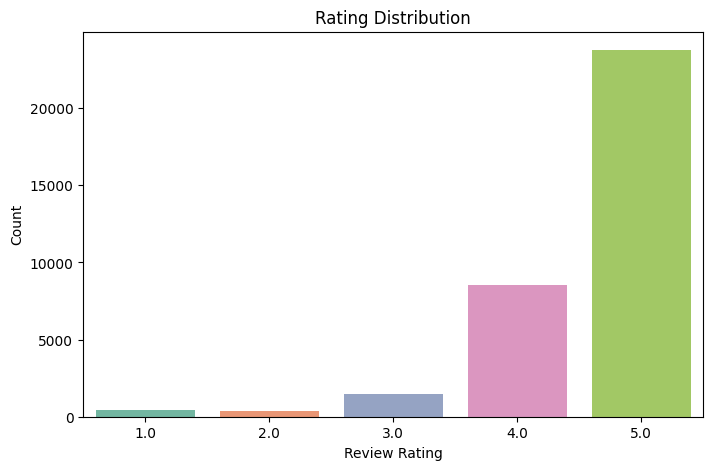

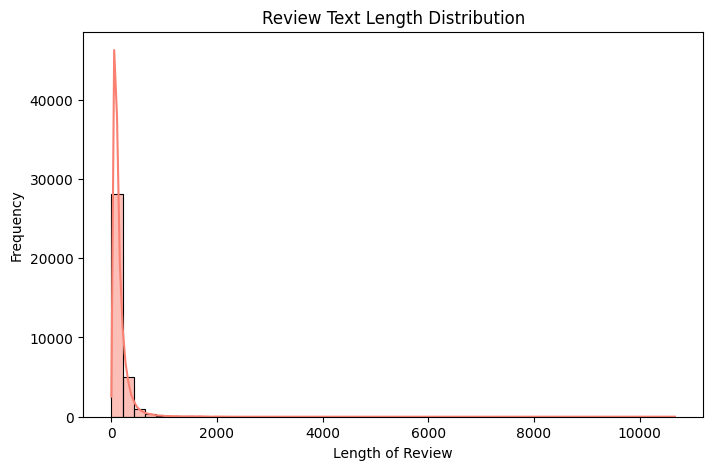

In [64]:
# ---- 🧠 EDA ----

print("\n🔍 Basic Info:")
print(df.info())

print("\n📊 Rating Distribution:")
print(df['rating'].value_counts())

plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=df, palette='Set2')
plt.title('Rating Distribution')
plt.xlabel('Review Rating')
plt.ylabel('Count')
plt.show()

df['review_length'] = df['review'].astype(str).apply(len)
plt.figure(figsize=(8, 5))
sns.histplot(df['review_length'], bins=50, kde=True, color='salmon')
plt.title('Review Text Length Distribution')
plt.xlabel('Length of Review')
plt.ylabel('Frequency')
plt.show()

In [65]:
# ---- 🏷️ Map Labels ----
def map_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating <= 2:
        return 'negative'
    else:
        return 'neutral'

df['label'] = df['rating'].apply(map_sentiment)
df = df[df['label'] != 'neutral']

In [66]:

# ---- 🧼 Text Cleaning ----
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", '', text)
    text = re.sub(r"\d+", '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

df['cleaned_text'] = df['review'].apply(clean_text)

print("\n🧹 Sample Cleaned Reviews:")
print(df[['review', 'cleaned_text']].head())


🧹 Sample Cleaned Reviews:
                                              review  \
0  This product so far has not disappointed. My c...   
1  great for beginner or experienced person. Boug...   
2  Inexpensive tablet for him to use and learn on...   
3  I've had my Fire HD 8 two weeks now and I love...   
4  I bought this for my grand daughter when she c...   

                                        cleaned_text  
0  product far disappointed child love use like a...  
1  great beginner experienced person bought gift ...  
2  inexpensive tablet use learn step nabi thrille...  
3  ive fire hd two week love tablet great valuewe...  
4  bought grand daughter come visit set user ente...  


In [67]:
# ---- ⚖️ Balance Dataset ----
positive_df = df[df['label'] == 'positive']
negative_df = df[df['label'] == 'negative']
positive_sample = positive_df.sample(n=len(negative_df), random_state=42)
balanced_df = pd.concat([positive_sample, negative_df]).sample(frac=1, random_state=42)

print("\n📊 Balanced Label Counts:")
print(balanced_df['label'].value_counts())


📊 Balanced Label Counts:
label
positive    812
negative    812
Name: count, dtype: int64


In [68]:
# ---- 📊 TF-IDF + Split ----
X_train, X_test, y_train, y_test = train_test_split(
    balanced_df['cleaned_text'], balanced_df['label'], test_size=0.2, random_state=42
)

vectorizer = TfidfVectorizer(max_df=0.7)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [69]:
# ---- 🔍 Logistic Regression ----
log_model = LogisticRegression()
log_model.fit(X_train_vec, y_train)
log_preds = log_model.predict(X_test_vec)

print("\n🔹 Logistic Regression")
print(classification_report(y_test, log_preds))
print(confusion_matrix(y_test, log_preds))


🔹 Logistic Regression
              precision    recall  f1-score   support

    negative       0.84      0.86      0.85       159
    positive       0.86      0.84      0.85       166

    accuracy                           0.85       325
   macro avg       0.85      0.85      0.85       325
weighted avg       0.85      0.85      0.85       325

[[137  22]
 [ 26 140]]


In [70]:
# ---- 🔍 Naive Bayes ----
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)
nb_preds = nb_model.predict(X_test_vec)

print("\n🔹 Naive Bayes")
print(classification_report(y_test, nb_preds))
print(confusion_matrix(y_test, nb_preds))


🔹 Naive Bayes
              precision    recall  f1-score   support

    negative       0.82      0.87      0.84       159
    positive       0.87      0.82      0.84       166

    accuracy                           0.84       325
   macro avg       0.84      0.84      0.84       325
weighted avg       0.84      0.84      0.84       325

[[138  21]
 [ 30 136]]


In [99]:
# ---- 🤖 Deep Learning with GRU (Keras) ----
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Tokenize and pad sequences
MAX_WORDS = 10000
MAX_LEN = 100
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(balanced_df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(balanced_df['cleaned_text'])
X = pad_sequences(sequences, maxlen=MAX_LEN)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(balanced_df['label'])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build GRU model
model = Sequential()
model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN))
model.add(GRU(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train GRU model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# Evaluate
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

print("\n🔍 Classification Report (GRU):")
print(classification_report(y_test, y_pred, target_names=le.classes_))



c:\Users\DELL\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.5345 - loss: 0.6918 - val_accuracy: 0.7154 - val_loss: 0.6743
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.8027 - loss: 0.6013 - val_accuracy: 0.8000 - val_loss: 0.4437
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.8930 - loss: 0.2799 - val_accuracy: 0.8000 - val_loss: 0.5524
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 192ms/step - accuracy: 0.9592 - loss: 0.1340 - val_accuracy: 0.7846 - val_loss: 0.8115
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.9830 - loss: 0.0658 - val_accuracy: 0.8154 - val_loss: 0.8100
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.9912 - loss: 0.0362 - val_accuracy: 0.7692 - val_loss: 1.0212
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.9924 - loss: 0.0426 - val_accuracy: 0.7692 - val_loss: 1.0000
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.9943 - loss: 0.0272 - val_accuracy: 0.80

In [100]:
# ---- 💾 Save Models ----
with open("logistic_model.pkl", "wb") as f:
    pickle.dump(log_model, f)

with open("naive_bayes_model.pkl", "wb") as f:
    pickle.dump(nb_model, f)

with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

print("\n✅ Models & Vectorizer saved!")

model.save("gru_sentiment_model.h5")

# Save tokenizer and label encoder
import pickle
with open("gru_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)



✅ Models & Vectorizer saved!


In [83]:
# ---- 💬 Sample Predictions ----
test_reviews = [
    "Absolutely terrible. I hated it.",
    "Fantastic quality and fast delivery!",
    "Not great, not horrible.",
    "This product is amazing!",
    "Worst purchase I've ever made.",
    "I hate this product."
]

cleaned_test = [clean_text(r) for r in test_reviews]
test_vec = vectorizer.transform(cleaned_test)

log_test_preds = log_model.predict(test_vec)
nb_test_preds = nb_model.predict(test_vec)

for i, review in enumerate(test_reviews):
    print(f"\nReview: {review}")
    print(f"🔹 Logistic Prediction: {log_test_preds[i]}")
    print(f"🔹 Naive Bayes Prediction: {nb_test_preds[i]}")


Review: Absolutely terrible. I hated it.
🔹 Logistic Prediction: negative
🔹 Naive Bayes Prediction: negative

Review: Fantastic quality and fast delivery!
🔹 Logistic Prediction: positive
🔹 Naive Bayes Prediction: positive

Review: Not great, not horrible.
🔹 Logistic Prediction: positive
🔹 Naive Bayes Prediction: positive

Review: This product is amazing!
🔹 Logistic Prediction: positive
🔹 Naive Bayes Prediction: positive

Review: Worst purchase I've ever made.
🔹 Logistic Prediction: negative
🔹 Naive Bayes Prediction: negative

Review: I hate this product.
🔹 Logistic Prediction: negative
🔹 Naive Bayes Prediction: negative


In [101]:
def predict_sentiment_gru(text):
    text_clean = clean_text(text)
    seq = tokenizer.texts_to_sequences([text_clean])
    padded = pad_sequences(seq, maxlen=MAX_LEN)
    pred = model.predict(padded)[0][0]
    label = le.inverse_transform([int(pred > 0.5)])
    return label[0]

# Example:
print(predict_sentiment_gru("This is the best product ever!"))
print(predict_sentiment_gru("worst product ever!"))
print(predict_sentiment_gru("I hate this product."))
print(predict_sentiment_gru("I Love it!"))
print(predict_sentiment_gru("worst purchase I've ever made."))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
negative


C:\Users\DELL\AppData\Local\Temp\ipykernel_16340\1991107443.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='coolwarm')


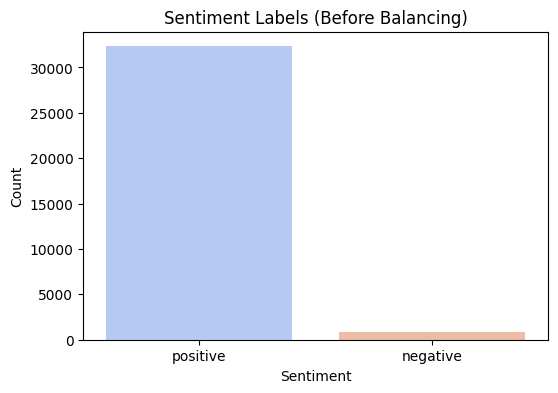

C:\Users\DELL\AppData\Local\Temp\ipykernel_16340\1991107443.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=balanced_df, palette='coolwarm')


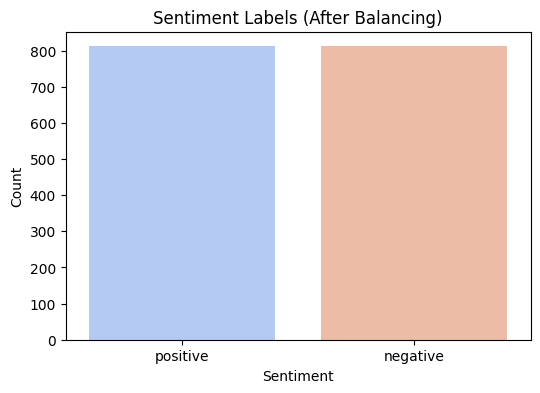

In [76]:
# After balancing into 'balanced_df'
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, palette='coolwarm')
plt.title('Sentiment Labels (Before Balancing)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=balanced_df, palette='coolwarm')
plt.title('Sentiment Labels (After Balancing)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


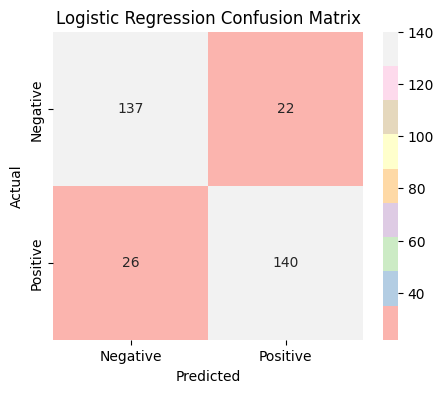

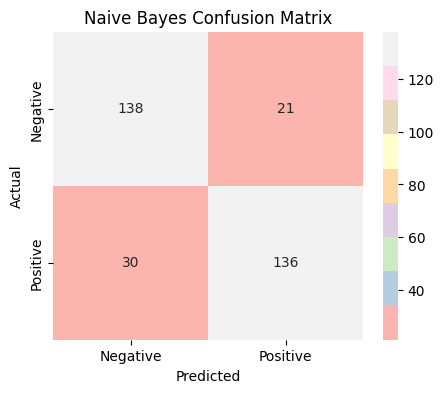

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder 
def plot_conf_matrix(y_true, y_pred, model_name='Model'):
    le = LabelEncoder() 
    y_pred_numeric = le.fit_transform(y_pred)  
    cm = confusion_matrix(y_true, y_pred_numeric, labels=le.transform(['negative', 'positive'])) 
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Pastel1',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# For Logistic Regression
plot_conf_matrix(y_test, log_preds, 'Logistic Regression')

# For Naive Bayes
plot_conf_matrix(y_test, nb_preds, 'Naive Bayes')

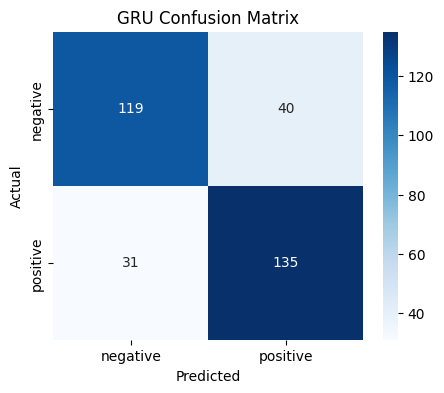

In [78]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("GRU Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
